# Define the ChatGPT Sentiment Predictor

In [5]:
#!pip install openai

In [2]:
import pandas as pd
import re
import os
from openai import OpenAI

class GPTSentimentPredictor:
    def __init__(self, model='gpt-4o-mini'): #or gpt-4o
        self.model = model
        self.file = 'ChatGPT Financial Dataset.csv'

        self.df = pd.read_csv(self.file, names = ['Sentiment', 'Sentence'], encoding='ISO-8859-1')

        # This implies we haven't processed the dataset before. Perform the necessary operations
        if 'Predicted' not in self.df.columns:
            # Use numeric values for ChatGPT
            self.df.Sentiment = self.df.Sentiment.map({'positive': 1, 'negative': -1, 'neutral': 0})
            self.df['Predicted'] = float('nan')

        # Set up auth key and initialize the API
        os.environ['OPENAI_API_KEY'] = ""### Place your auth key in this variable ###
        self.client = OpenAI()

    def save(self, done = False):
        if done:
            self.df['Predicted'] = self.df['Predicted'].astype('int64')
        self.df.to_csv(self.file, index=False)

    def predict(self, sentence):
        system_msg = '''You are a macroeconomic researcher at the finance industry, specializing in financial sentiment analysis to support investment decisions. Given your background in Finance and Sentiment Analysis, you must classify the sentiment for provided financial sentence using one of the following: 1 for positive, 0 for neutral and -1 for negative. 
        You should only provide the numeric score in your response.'''
        user_msg = 'Classify the sentence provided below:\n'

        # Invoke the chat completions API
        chat = self.client.chat.completions.create(
            model=self.model,
            messages=[
                {'role': 'system', 'content': system_msg},
                {'role': 'user', 'content': user_msg + sentence}
            ],
            temperature=0,
        )

        # Obtain the prediction
        chat_content = chat.choices[0].message.content
        prediction = re.search(r'(1|0|-1)', chat_content).group()
        
        if not prediction:
            raise Exception("No prediction found!")
            
        return prediction
        
    def run(self):
        # Loop through all the entries in the target dataset
        for i in range(len(self.df)):
            # This is a workaround to handle ChatGPT API calls getting slower and slower...
            if not pd.isna(self.df.iloc[i].Predicted): continue
            
            try:
                # Get Prediction using ChatGPT
                result = self.predict(self.df.iloc[i].Sentence)
                print(f'{i}: {result}')

                # Update df
                self.df.at[i, 'Predicted'] = result

            except Exception as err:
                # Error handling
                print(f'{i}: {err}')
                continue

# Use ChatGPT Sentiment Predictor for Predictions

In [3]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

In [8]:
predictor = GPTSentimentPredictor()
predictor.run()
predictor.save(done=True)

0: 0


C:\Users\60178\AppData\Local\Temp\ipykernel_19300\2489253253.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.df.at[i, 'Predicted'] = result


1: 0
2: -1
3: 1
4: 1
5: 1
6: 0
7: 1
8: 1
9: 1
10: 1
11: 1
12: 0
13: 1
14: 1
15: 1
16: 1
17: 1
18: 1
19: 1
20: 1
21: 0
22: 1
23: 1
24: 1
25: 1
26: 1
27: 1
28: 0
29: 0
30: 1
31: 1
32: 1
33: 1
34: 1
35: 1
36: 1
37: 1
38: 1
39: 1
40: 1
41: 1
42: 0
43: 0
44: 1
45: 1
46: 1
47: 0
48: 1
49: 1
50: 1
51: 1
52: 0
53: 1
54: 1
55: 1
56: 1
57: 0
58: 0
59: 0
60: 1
61: 0
62: 0
63: 0
64: 1
65: 0
66: 0
67: 0
68: 0
69: 0
70: 1
71: 0
72: 0
73: 0
74: 0
75: 0
76: 0
77: 1
78: 0
79: 0
80: 0
81: 0
82: 0
83: 1
84: 1
85: 0
86: 0
87: 1
88: 1
89: 1
90: 1
91: 0
92: 1
93: 1
94: 1
95: 1
96: 1
97: 1
98: 1
99: 1
100: 1
101: 1
102: 1
103: 1
104: 1
105: 1
106: 1
107: 1
108: 1
109: 1
110: 0
111: 1
112: 1
113: 1
114: 1
115: 0
116: 1
117: 1
118: 1
119: 1
120: 1
121: 1
122: 1
123: 0
124: 1
125: 1
126: 1
127: 1
128: 1
129: 1
130: 1
131: 1
132: 1
133: 1
134: 1
135: 1
136: 0
137: 0
138: 1
139: 0
140: 1
141: 0
142: 1
143: 1
144: 1
145: 1
146: 0
147: 1
148: 1
149: 1
150: 1
151: 1
152: 1
153: 1
154: 1
155: 1
156: 1
157: 1
158: 1
1

In [9]:
# If the call to ChatGPT API is getting slower and slower, interrupt the kernel, and save the predictions so far using the following code
#predictor.save()

# Performance

<Axes: >

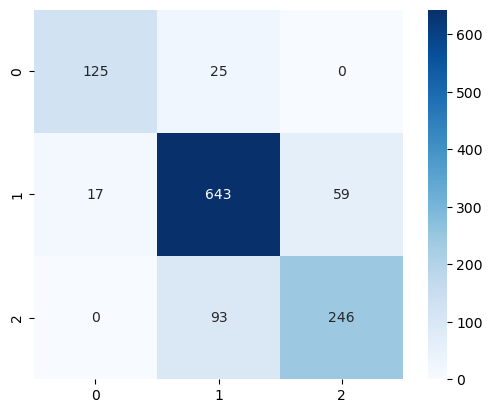

In [9]:
# Confusion Matrix
labels = [-1,0,1]
data = confusion_matrix(predictor.df.Sentiment, predictor.df.Predicted, labels=labels)
data = (data * 1212 / data.sum()).astype(int) # Normalise test set size, 1212
sns.heatmap(data, square=True, annot=True, cmap='Blues', fmt='d')

In [10]:
# Accuracy
accuracy_score(predictor.df.Sentiment, predictor.df.Predicted)

0.8382170862567065

In [11]:
# F1 Score
f1_score(predictor.df.Sentiment, predictor.df.Predicted, average='macro')

0.8278560509629199